In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [3]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Vietnam,Newbritain)


for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp()
    

ghats
vietnam
newbritain


In [4]:
for MR in MRs:
    print(MR.name)
    MR.set_daily_spavg_var('162_071_viwve','VIWVE','vinteg',where='upstream')
    MR.set_daily_spavg_var('162_072_viwvn','VIWVN','vinteg',where='upstream')
    MR.set_viwvperp_sfc()
    MR.set_daily_imerg()
    MR.set_daily_sfc_var('128_034_sstk','SST')
    MR.vars['UBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['VBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.set_daily_Blsimple_vars('semi')
    
    for varname in 'SST','EBSEMI','TLSEMI','QLSEMI','EBSEMI','BLSEMISIMPLE','GPM_PR':
        grid = MR.vars[varname+'_DAILY']
        MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)

    

ghats
vietnam
newbritain


# Fig - Global Pr maps

In [3]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


In [16]:
def plot_box(ax,box,c='b',lw=3):
    ax.add_patch(mpatches.Rectangle(xy=[box[0], box[2]], width=box[1]-box[0], height=box[3]-box[2],
                                   edgecolor=c,
                                   fill = False,
                                   lw=lw,
                                   linestyle='-',
                                   transform=ccrs.PlateCarree()))
    


In [5]:
def lon_360_to_180(ds):
    ds2=ds.copy()
    ds2.coords['longitude'] = (ds2.coords['longitude'] + 180) % 360 -180
    return ds2.sortby(ds2.longitude)

In [6]:
gpm_pr_seasmean_plot    = lon_360_to_180(gpm_pr_seasmean   )
era5100u_seasmean_plot  = lon_360_to_180(era5100u_seasmean )
era5100v_seasmean_plot  = lon_360_to_180(era5100v_seasmean )
orogm_plot              = lon_360_to_180(orogm             )

## seed talk

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
def cross_section(prjja,prond,orog,lon1,lon2,lat,ax):
    """Plot a cross section of orography, JJA and OND precip at a given latitude and between two given longitudes """
    ax2=ax.twinx()
    prjja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='Mean precipitation',linewidth=3)#
    prond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='3 windiest years',linewidth=3)#
    orog.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation ',linewidth=3)#
    
    ax.set_xlabel('')
    ax.set_ylabel('Z (m)')
    ax.set_xlim((lon1,lon2))
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_title('')
    ax2.set_title('')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    return ax2

def cross_section2(prjja,orog,lon1,lon2,lat,ax):
    """Plot a cross section of orography, JJA and OND precip at a given latitude and between two given longitudes """
    ax2=ax.twinx()
    prjja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='Mean precipitation',linewidth=3)#
    orog.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation ',linewidth=3)#
    
    ax.set_xlabel('')
    ax.set_ylabel('Z (m)')
    ax.set_xlim((lon1,lon2))
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_title('')
    ax2.set_title('')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    return ax2

def jjamean(pr):
    return pr.sel(month=slice(7,9)).mean('month')

In [28]:
topo_hires_smooth =np.maximum(xr.apply_ufunc(gaussian_filter,topo_hires  ,kwargs={"sigma":2.5}),0.)

In [30]:
gpm_pr_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2020.nc")
era5100u_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2020.nc")


In [33]:
u_timeseries = era5100u_monthly.sel(latitude = slice(18,16),longitude=slice(60,140)).mean(['latitude','longitude'])
u_timeseries = u_timeseries.sel(time=((u_timeseries['time.month']>=6)&(u_timeseries['time.month']<=8))).groupby('time.year').mean()
gpm_pr_jja_yearly=gpm_pr_monthly.sel(time=((gpm_pr_monthly['time.month']>=6)&(gpm_pr_monthly['time.month']<=8))).groupby('time.year').mean()


In [51]:
condmean = gpm_pr_jja_yearly.where(u_timeseries>=4).mean('year')

In [50]:
np.quantile(u_timeseries,0.75)

3.929305076599121

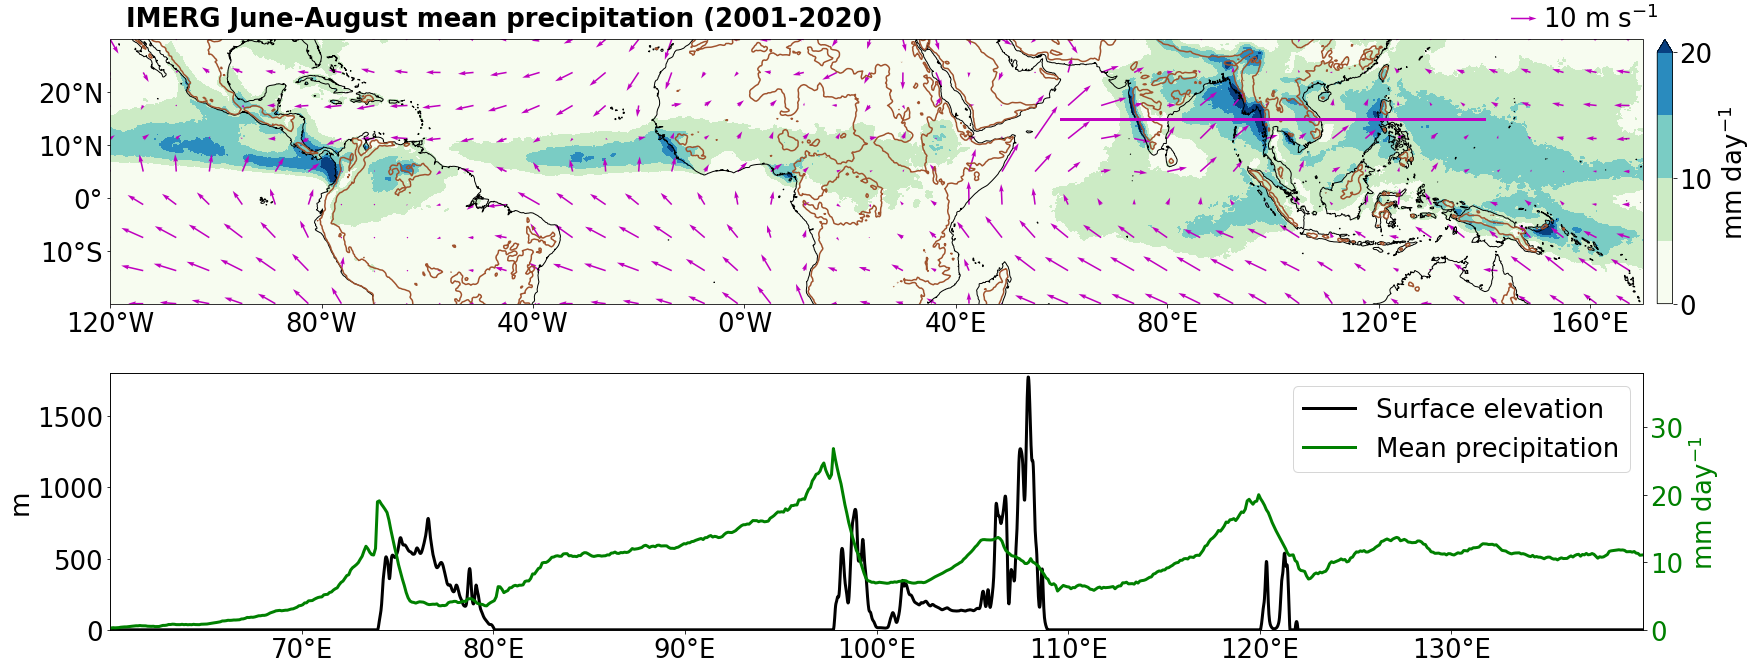

In [59]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(25,10))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [5,4],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[1])

#Precipitation shadings
c = jjamean(gpm_pr_seasmean_plot).sel(latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'label':'precip (mm/day)','anchor':[1,-0.5]})

#wind vectors
n=25
m=n
u= jjamean(era5100u_seasmean_plot).sel(latitude=slice(30,-30),longitude=slice(-120,170))
v= jjamean(era5100v_seasmean_plot).sel(latitude=slice(30,-30),longitude=slice(-120,170))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

a=ax
orogm_plot.sel(latitude=slice(30,-30),longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='sienna',linewidths=[1.5])
#Latitude line
a.plot([60,140],[15,15],color='m',linewidth=3)
a.coastlines()
a.set_ylim(-20,30)
a.set_xlim(-120,170)
a.set_title("")
a.set_xticks(range(-120,170,40), crs=ccrs.PlateCarree())
a.set_yticks(range(-10,30,10), crs=ccrs.PlateCarree())
#a.tick_params(labelsize=20)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
a.xaxis.set_major_formatter(lon_formatter)
a.yaxis.set_major_formatter(lat_formatter)
a.set_xlabel("")
a.set_ylabel("")

# Colorbar
pad=.2;size="1%"
divider = make_axes_locatable(a)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,ticks=(0,10,20),label=r'mm day$^{-1}$')

# Quiver key (reference wind arrow)
qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                   coordinates='axes',color='m')


#Cross-section (third panel)
ax3=cross_section2(jjamean(gpm_pr_seasmean_plot),topo_hires_smooth,60,140,15,ax2)
#ax3=cross_section(jjamean(gpm_pr_seasmean_plot),condmean,topo_hires_smooth,60,140,15,ax2)
#Make third panel the same width as panels a and b
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1800)
ax3.set_ylim(0,38)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel(r'mm day$^{-1}$',color='g')

#Panel labels
ax.text(0.01, 1.05,'IMERG June-August mean precipitation (2001-2020)', transform=ax.transAxes,color='k',weight='bold')

fig.tight_layout()

## main

Text(0.01, 1.05, 'November mean')

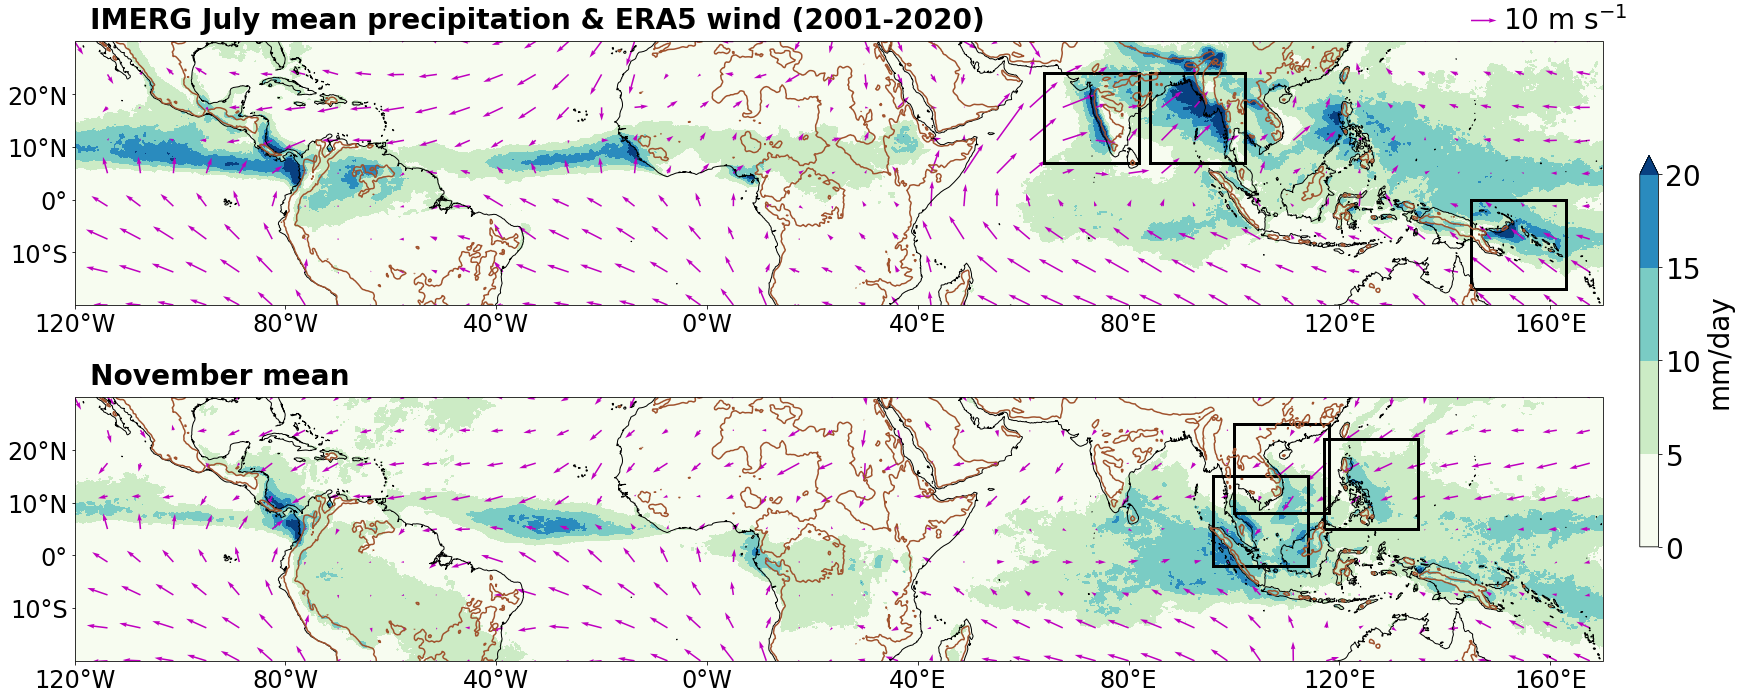

In [21]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs = plt.subplots(2,1,figsize=(33,12),subplot_kw = {'projection': ccrs.PlateCarree()})
(ax,ax2)=axs
#Precipitation shadings
im1 = gpm_pr_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'label':'precip (mm/day)','anchor':[1,-0.5]})
im2 = gpm_pr_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax2,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

#wind vectors
n=25
m=n
u=era5100u_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

u=era5100u_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
ax2.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

for a in ax,ax2:
    orogm_plot.sel(latitude=slice(30,-30),longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='sienna',linewidths=[1.5])
    a.coastlines()
    a.set_ylim(-20,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,40), crs=ccrs.PlateCarree())
    a.set_yticks(range(-10,30,10), crs=ccrs.PlateCarree())
    a.tick_params(labelsize=24)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
plot_box(ax,Ghats.box       ,c='k')
plot_box(ax,Myanmar.box     ,c='k')
plot_box(ax,Newbritain.box  ,c='k')
plot_box(ax2,Malaysia.box   ,c='k')
plot_box(ax2,Philippines.box,c='k')
plot_box(ax2,Vietnam.box    ,c='k')

qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                   coordinates='axes',color='m')

cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.6,label='mm/day',pad=0.02)

#Panel labels
ax.text(0.01, 1.05,'IMERG July mean precipitation & ERA5 wind (2001-2020)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'November mean', transform=ax2.transAxes,color='k',weight='bold')

#fig.tight_layout()

Text(0.01, 1.05, 'November mean')

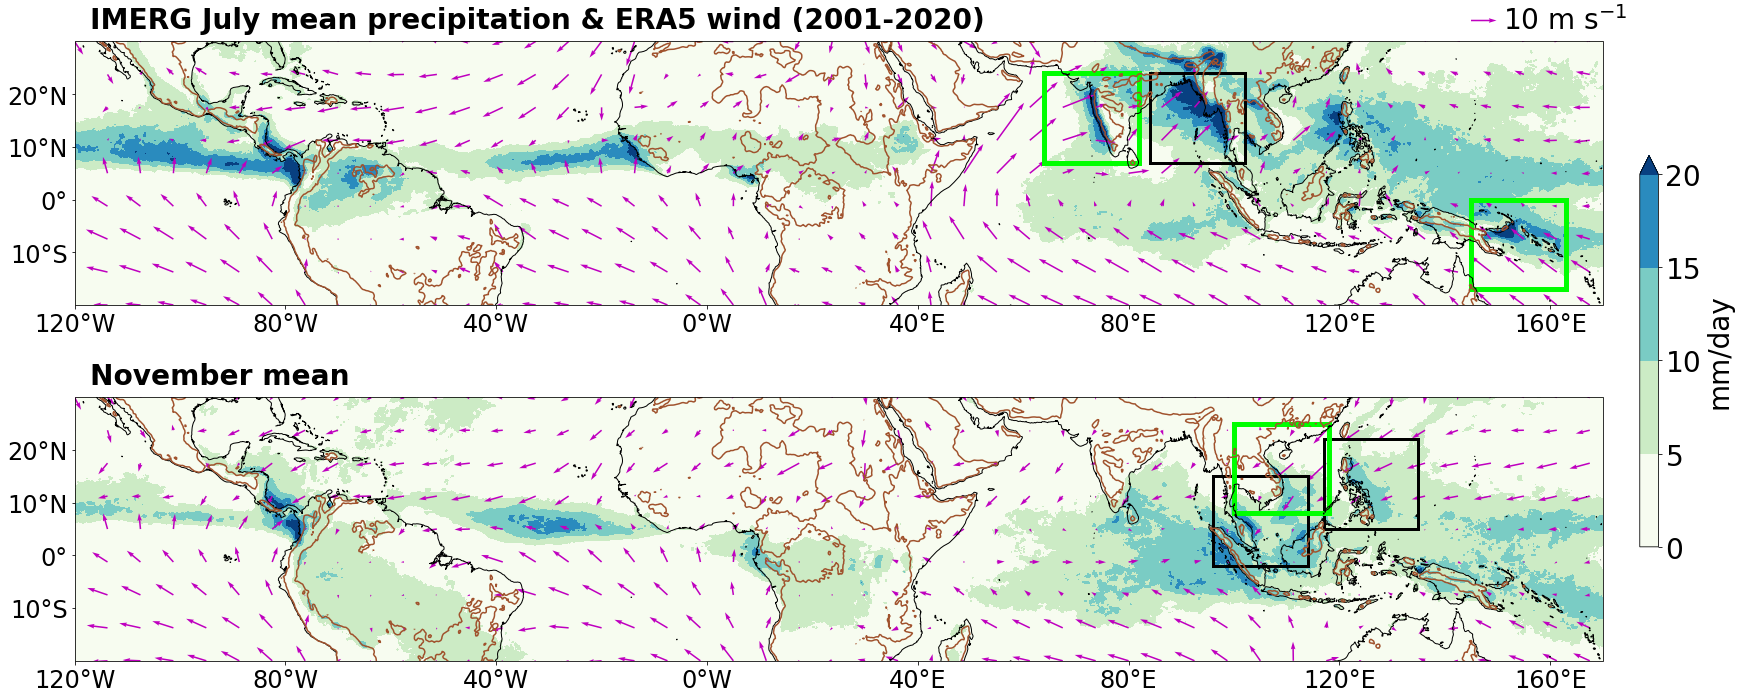

In [19]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs = plt.subplots(2,1,figsize=(33,12),subplot_kw = {'projection': ccrs.PlateCarree()})
(ax,ax2)=axs
#Precipitation shadings
im1 = gpm_pr_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'label':'precip (mm/day)','anchor':[1,-0.5]})
im2 = gpm_pr_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax2,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

#wind vectors
n=25
m=n
u=era5100u_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

u=era5100u_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
ax2.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

for a in ax,ax2:
    orogm_plot.sel(latitude=slice(30,-30),longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='sienna',linewidths=[1.5])
    a.coastlines()
    a.set_ylim(-20,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,40), crs=ccrs.PlateCarree())
    a.set_yticks(range(-10,30,10), crs=ccrs.PlateCarree())
    a.tick_params(labelsize=24)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
plot_box(ax,Ghats.box       ,c='lime',lw=5)
plot_box(ax,Myanmar.box     ,c='k')
plot_box(ax,Newbritain.box  ,c='lime',lw=5)
plot_box(ax2,Malaysia.box   ,c='k')
plot_box(ax2,Philippines.box,c='k')
plot_box(ax2,Vietnam.box    ,c='lime',lw=5)

qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                   coordinates='axes',color='m')

cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.6,label='mm/day',pad=0.02)

#Panel labels
ax.text(0.01, 1.05,'IMERG July mean precipitation & ERA5 wind (2001-2020)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'November mean', transform=ax2.transAxes,color='k',weight='bold')

#fig.tight_layout()

# Fig - theory  - seed talk

In [49]:
from orographicConvectionTheory.orographicConvectionTheory import *

In [50]:
def linear_mountain_wave_w(h,N,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    h_hat = np.fft.fft(h)
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
    return w
def upslope_w(h,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    h_hat = np.fft.fft(h)
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( 0  *  z[None,:]) 
    wnp=np.real(np.fft.ifft(w_hat,axis=0))
    wnp[np.abs(wnp)<0.001]=0.
    w=xr.DataArray(wnp,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return w
def linear_Td(h,N,U,x,z):
    cp = 1004. #Heat capacity of air in J/kg/K
    k=k_vector(len(x),x[1]-x[0])
    ds0dz = cp*300*N**2/9.81
    Tdhat = -ds0dz*np.fft.fft(h)[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:])
    Td=xr.DataArray(np.real(np.fft.ifft(Tdhat,axis=0))/cp,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return Td

def linear_zeta(h,N,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    zetahat = np.fft.fft(h)[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:])
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0))/cp,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return zeta

In [51]:
x,hx = topographic_profile('cos',A=1000)
z=np.arange(0,10e3,100)
w_lin = linear_mountain_wave_w(hx,0.012,10,x,z)
w_ups = upslope_w(hx,10,x,z)
Td_lin = linear_Td(hx,0.012,10,x,z)
zeta_lin = linear_zeta(hx,0.012,10,x,z)

In [52]:
Td_lin_2 = linear_Td(hx,0.012,14,x,z)

(-1000000.0, 1000000.0)

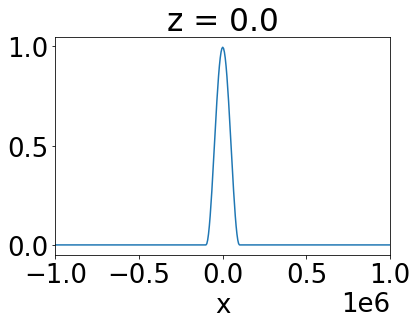

In [108]:
zeta_lin[:,0].plot()
plt.xlim(-1e6,1e6)

Text(0.5, 1.0, '')

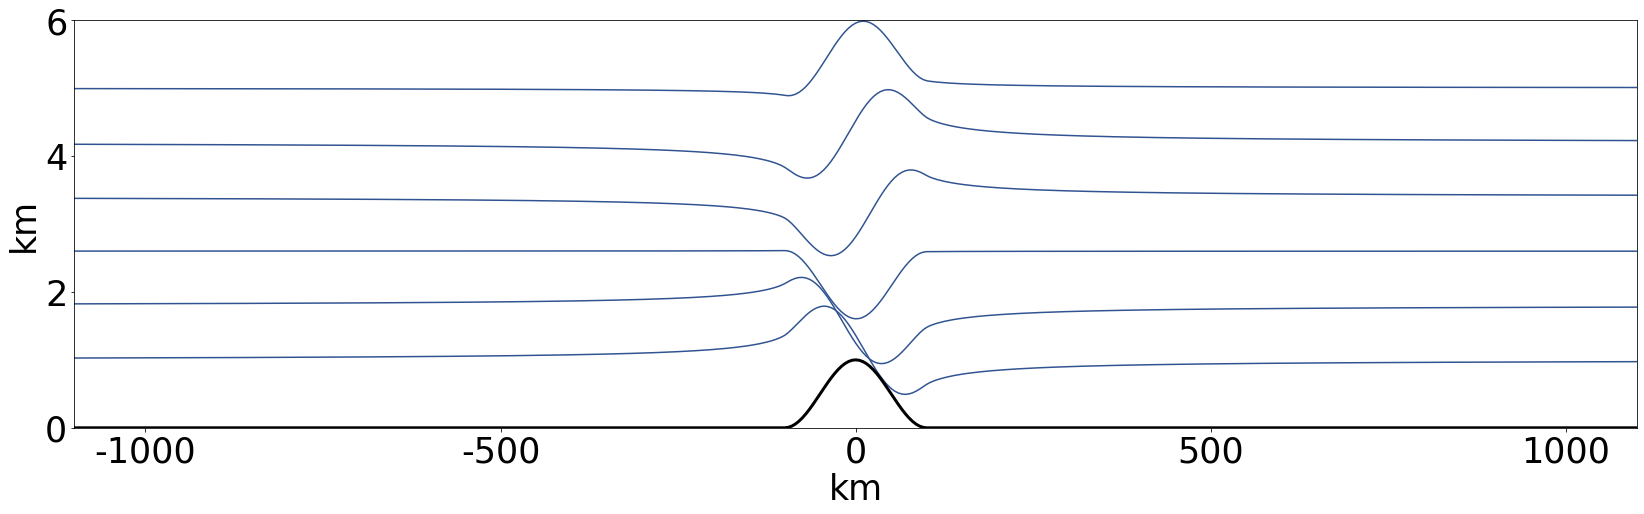

In [123]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7.5))

for idx in range(10,55,8):
    (zeta_lin.z[idx]+zeta_lin[:,idx]*1e3).plot(ax=ax,color='#305391')
ax.set_xlim(-1100e3,1100e3)
ax.plot(x,hx,color='k',linewidth=3)
ax.fill_between(x,0*x,hx,color='w')
ax.set_xticks(list(np.arange(-1000,1100,500)*1e3))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')
ax.set_yticks(np.arange(0,7,2)*1e3)
ax.set_yticklabels(np.arange(0,7,2))
ax.set_ylabel('km')
ax.set_ylim(0,6000)

#Plin_us = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5)
#ax2.plot(x,Plin_us,color='limegreen',linewidth=3)
#ax2.set_ylim(0,50)
#ax2.set_ylabel("mm/day")
ax.set_title('')

(0.0, 6000.0)

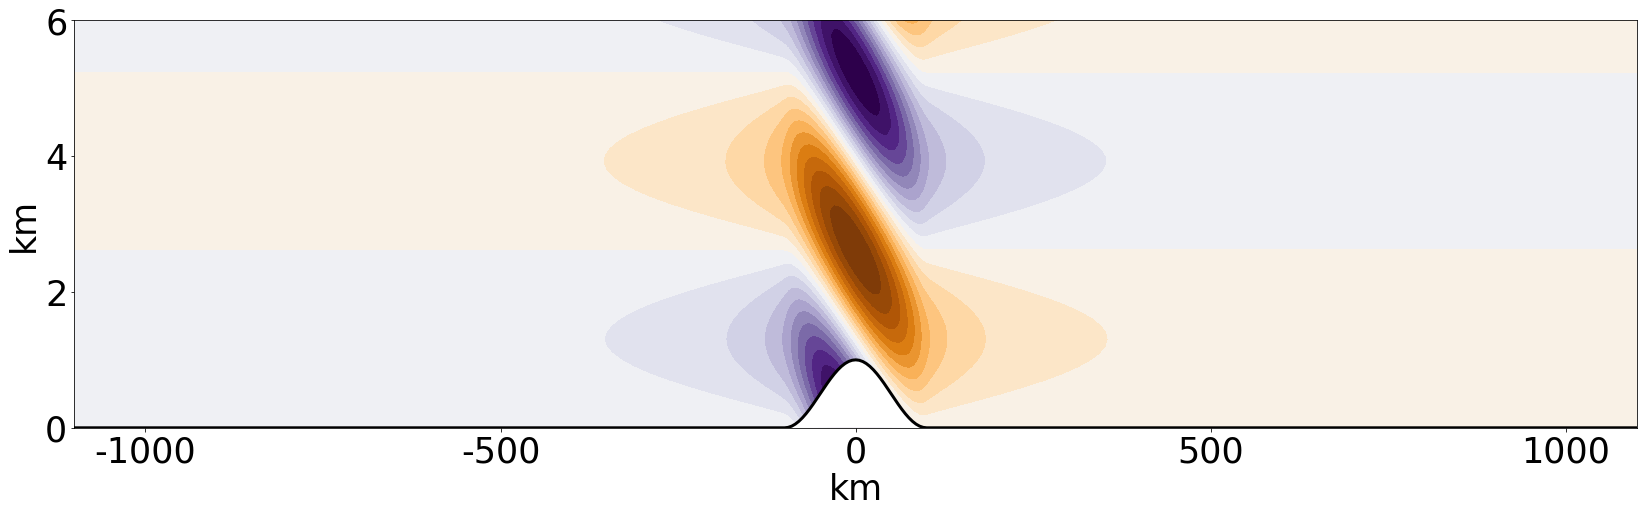

In [124]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7.5))

Td_lin.plot.contourf(ax=ax,y='z',levels=np.linspace(-4,4,21),cmap = plt.cm.PuOr_r,add_colorbar=False)
ax.set_xlim(-1100e3,1100e3)
ax.plot(x,hx,color='k',linewidth=3)
ax.fill_between(x,0*x,hx,color='w')
ax.set_xticks(list(np.arange(-1000,1100,500)*1e3))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')
ax.set_yticks(np.arange(0,7,2)*1e3)
ax.set_yticklabels(np.arange(0,7,2))
ax.set_ylabel('km')
ax.set_ylim(0,6000)

#Plin_us = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5)
#ax2.plot(x,Plin_us,color='limegreen',linewidth=3)
#ax2.set_ylim(0,50)
#ax2.set_ylabel("mm/day")

Text(0, 0.5, 'mm/day')

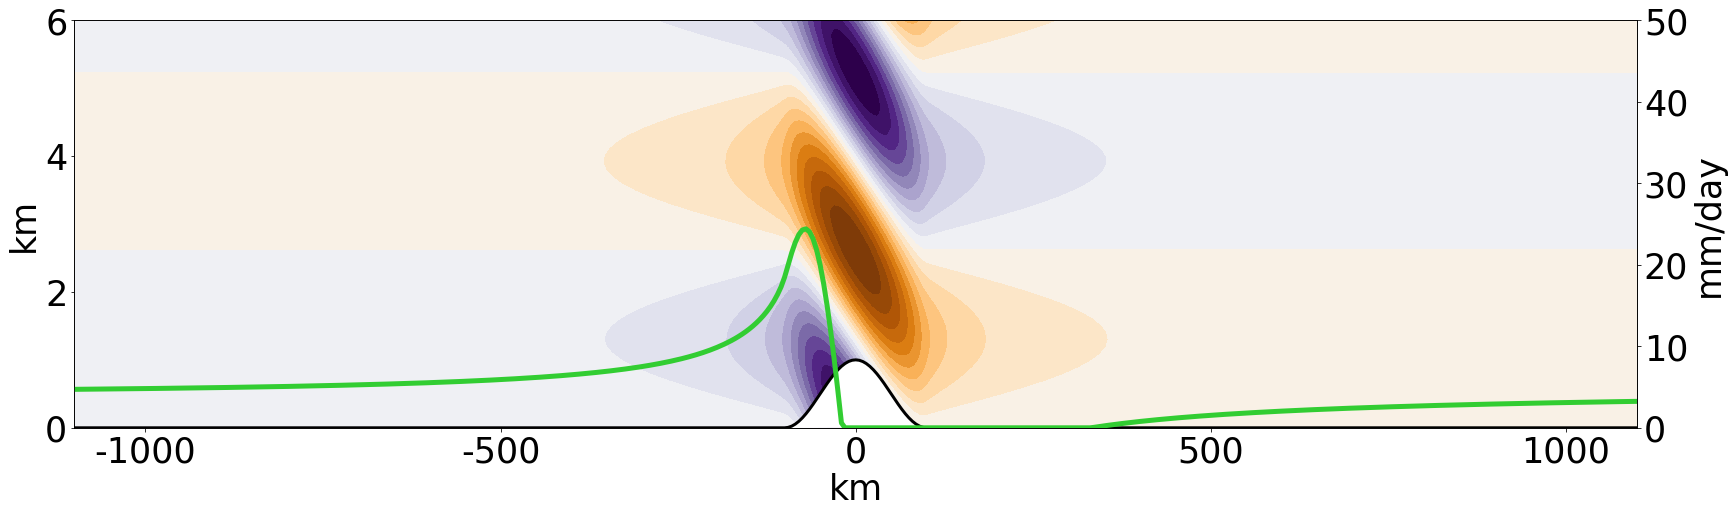

In [127]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7.5))
ax2 = ax.twinx()


Td_lin.plot.contourf(ax=ax,y='z',levels=np.linspace(-4,4,21),cmap = plt.cm.PuOr_r,add_colorbar=False)
ax.set_xlim(-1100e3,1100e3)
ax.plot(x,hx,color='k',linewidth=3)
ax.fill_between(x,0*x,hx,color='w')
ax.set_xticks(list(np.arange(-1000,1100,500)*1e3))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')
ax.set_yticks(np.arange(0,7,2)*1e3)
ax.set_yticklabels(np.arange(0,7,2))
ax.set_ylabel('km')
ax.set_ylim(0,6000)

Plin_us = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5)
ax2.plot(x,Plin_us,color='limegreen',linewidth=5)
ax2.set_ylim(0,50)
ax2.set_ylabel("mm/day")

(0.0, 6000.0)

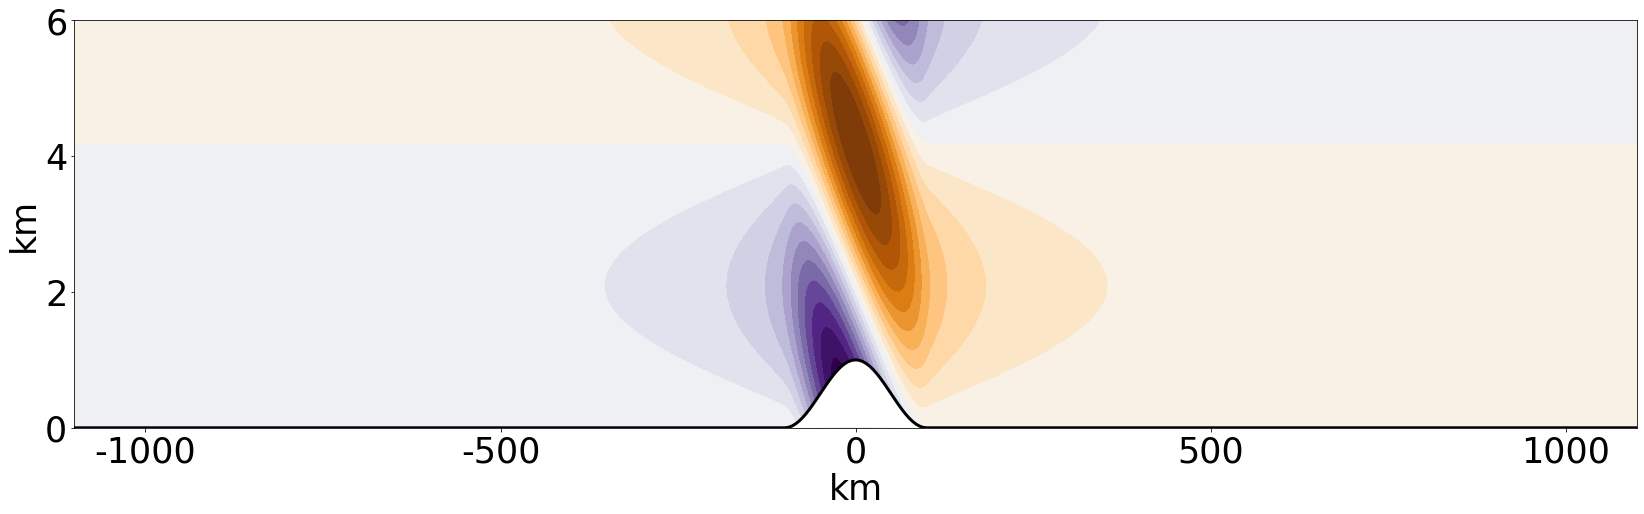

In [56]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7.5))

Td_lin_2 = linear_Td(hx,0.012,16,x,z)
Td_lin_2.plot.contourf(ax=ax,y='z',levels=np.linspace(-4,4,21),cmap = plt.cm.PuOr_r,add_colorbar=False)
ax.set_xlim(-1100e3,1100e3)
ax.plot(x,hx,color='k',linewidth=3)
ax.fill_between(x,0*x,hx,color='w')
ax.set_xticks(list(np.arange(-1000,1100,500)*1e3))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')
ax.set_yticks(np.arange(0,7,2)*1e3)
ax.set_yticklabels(np.arange(0,7,2))
ax.set_ylabel('km')
ax.set_ylim(0,6000)

#Plin_us = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5)
#ax2.plot(x,Plin_us,color='limegreen',linewidth=3)
#ax2.set_ylim(0,50)
#ax2.set_ylabel("mm/day")

# Figs - WRF simulations precip - seed talk

In [3]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client()
client

<Client: 'tcp://127.0.0.1:38195' processes=8 threads=64, memory=540.14 GB>

In [4]:
from orographicPrecipitation.wrfProcessing.wrf_hr_utils import *

In [5]:
deepinput_500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
deepchannel_500 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
deepchannel_500_new = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')

deepchannel_500_12 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')

deepchannel_500_296K = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/')


In [8]:
hrhgt = deepinput_500.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

In [9]:
def ratio_CI(pr1,pr2,unit,norm=1):
    pr1=np.array(pr1); pr2=np.array(pr2)
    nt1=len(pr1);nt2=len(pr2)
    sigma1=np.std(pr1.mean(axis=(1,2)));sigma2=np.std(pr2.mean(axis=(1,2)))
    
    meanratio = pr2.mean()/pr1.mean()
    deltaratio = meanratio * np.sqrt( (2*sigma1/np.sqrt(nt1)/pr1.mean())**2 + (2*sigma2/np.sqrt(nt2)/pr2.mean())**2)
    
    print("Change is %.1f %%/%s (95%% CI = [%.1f to %.1f])"%(100*(meanratio-1)/norm,unit,100*(meanratio-1-deltaratio)/norm,100*(meanratio-1+deltaratio)/norm))

In [10]:
deepchannel_500precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.days0-200.nc")
deepchannel_500_newprecip = deepchannel_500_new.RAINNC.diff('Time').load()*4
dp500_10pr = 0.5*(deepchannel_500precip[200:].mean(['south_north','Time']).load() + deepchannel_500_newprecip[8:].mean(['south_north','Time']).load())
dp500_10std = np.sqrt(0.5*(deepchannel_500precip[200:].mean('south_north').std('Time').load()**2 + deepchannel_500_newprecip[8:].mean('south_north').std('Time').load()**2))



In [11]:
deepchannel_500_12precip = deepchannel_500_12.RAINNC.diff('Time').load()*4
dp500_12pr = deepchannel_500_12precip[200:].mean(['south_north','Time']).load()
dp500_12std = deepchannel_500_12precip[200:].mean('south_north').std('Time').load()


In [12]:
deepchannel_500_296Kprecip = deepchannel_500_296K.RAINNC.diff('Time').load()*4
dp500_296Kpr = deepchannel_500_296Kprecip[200:].mean(['south_north','Time']).load()
dp500_296Kstd = deepchannel_500_296Kprecip[200:].mean('south_north').std('Time').load()


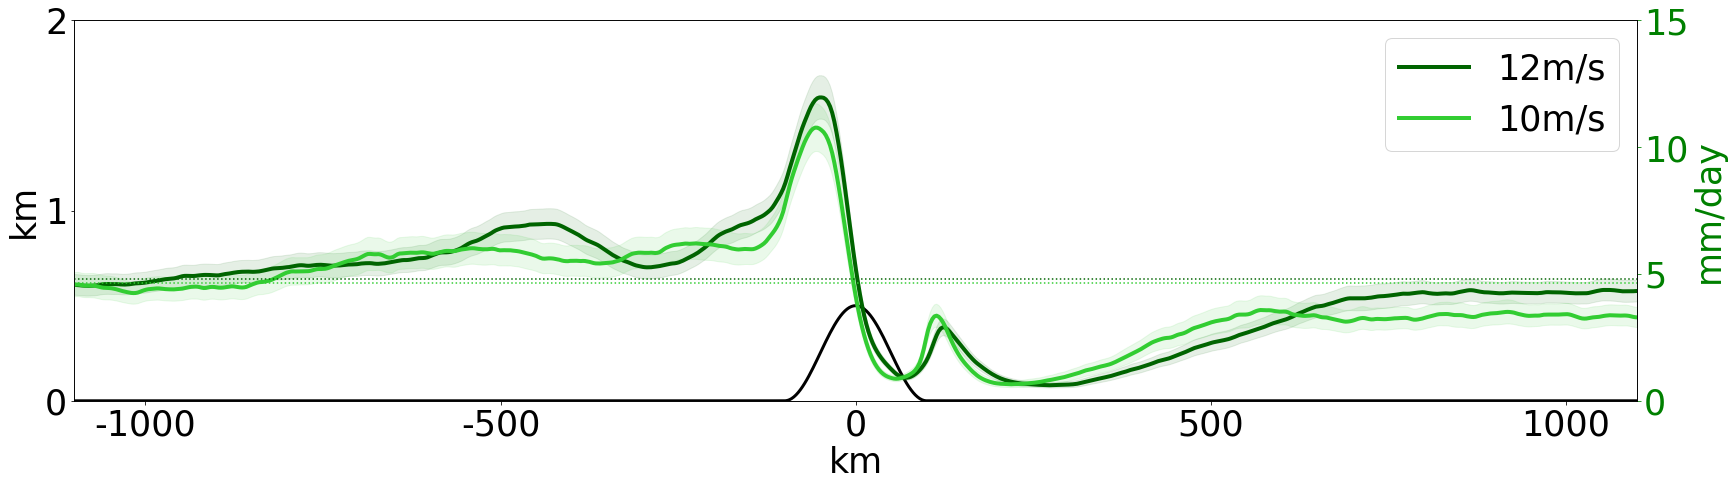

In [42]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7))
ax2 = ax.twinx()

ax.plot(hrdist,hrhgt,color='k',linewidth=3)


ax2.plot(hrdist,dp500_12pr,linewidth=4,color='darkgreen',label='12m/s')
ax2.plot(hrdist,dp500_10pr,linewidth=4,color='limegreen',label='10m/s')

ax2.fill_between(hrdist,dp500_12pr-2*dp500_12std/np.sqrt(1273),dp500_12pr+2*dp500_12std/np.sqrt(1273),alpha=0.1,color='darkgreen')
ax2.fill_between(hrdist,dp500_10pr-2*dp500_10std/np.sqrt(1052),dp500_10pr+2*dp500_10std/np.sqrt(1052),alpha=0.1,color='limegreen')

ax2.axhline(dp500_12pr[2200:3000].mean(),color='darkgreen',linestyle=':')
ax2.axhline(dp500_10pr[2200:3000].mean(),color='limegreen'  ,linestyle=':')
    

ax.set_xlim(-1100,1100)
ax.set_xticks(list(np.arange(-1000,1100,500)))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')

ax.set_yticks(np.arange(0,2500,1000))
ax.set_yticklabels([0,1,2])
ax.set_ylabel('km')
ax.set_ylim(0,2000)

ax2.set_ylabel('mm/day',color='green')
ax2.tick_params(axis='y', colors='green')
ax2.set_ylim(0,15)

ax.set_title('')
ax2.legend()

In [32]:
dp500_12pr.max()/dp500_10pr.max()

<xarray.DataArray 'RAINNC' ()>
array(1.11046315)

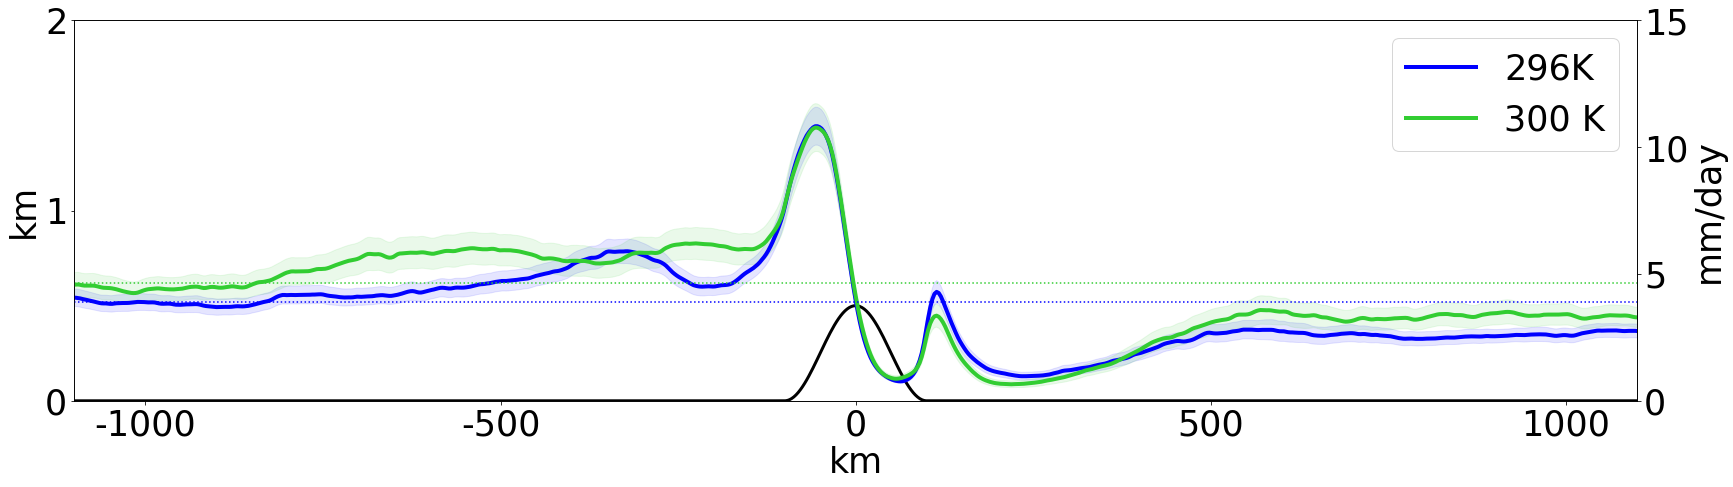

In [37]:
matplotlib.rcParams.update({'font.size': 35})
_,ax=plt.subplots(1,1,figsize=(28,7))
ax2 = ax.twinx()

ax.plot(hrdist,hrhgt,color='k',linewidth=3)


ax2.plot(hrdist,dp500_296Kpr,linewidth=4,color='b',label='296K')
ax2.plot(hrdist,dp500_10pr,linewidth=4,color='limegreen',label='300 K')

ax2.fill_between(hrdist,dp500_296Kpr-2*dp500_296Kstd/np.sqrt(1273),dp500_296Kpr+2*dp500_296Kstd/np.sqrt(1273),alpha=0.1,color='b')
ax2.fill_between(hrdist,dp500_10pr-2*dp500_10std/np.sqrt(1052),dp500_10pr+2*dp500_10std/np.sqrt(1052),alpha=0.1,color='limegreen')

ax2.axhline(dp500_296Kpr[2200:3000].mean(),color='b',linestyle=':')
ax2.axhline(dp500_10pr[2200:3000].mean(),color='limegreen'  ,linestyle=':')
    

ax.set_xlim(-1100,1100)
ax.set_xticks(list(np.arange(-1000,1100,500)))
ax.set_xticklabels(np.arange(-1000,1100,500))
ax.set_xlabel('km')

ax.set_yticks(np.arange(0,2500,1000))
ax.set_yticklabels([0,1,2])
ax.set_ylabel('km')
ax.set_ylim(0,2000)

ax2.set_ylabel('mm/day',color='green')
ax2.tick_params(axis='y', colors='green')
ax2.set_ylim(0,15)

ax.set_title('')
ax2.legend()

In [39]:
dp500_10pr.max()/dp500_296Kpr.max()

<xarray.DataArray 'RAINNC' ()>
array(0.99485442)

# Fig - Precip in 3 regions

In [32]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

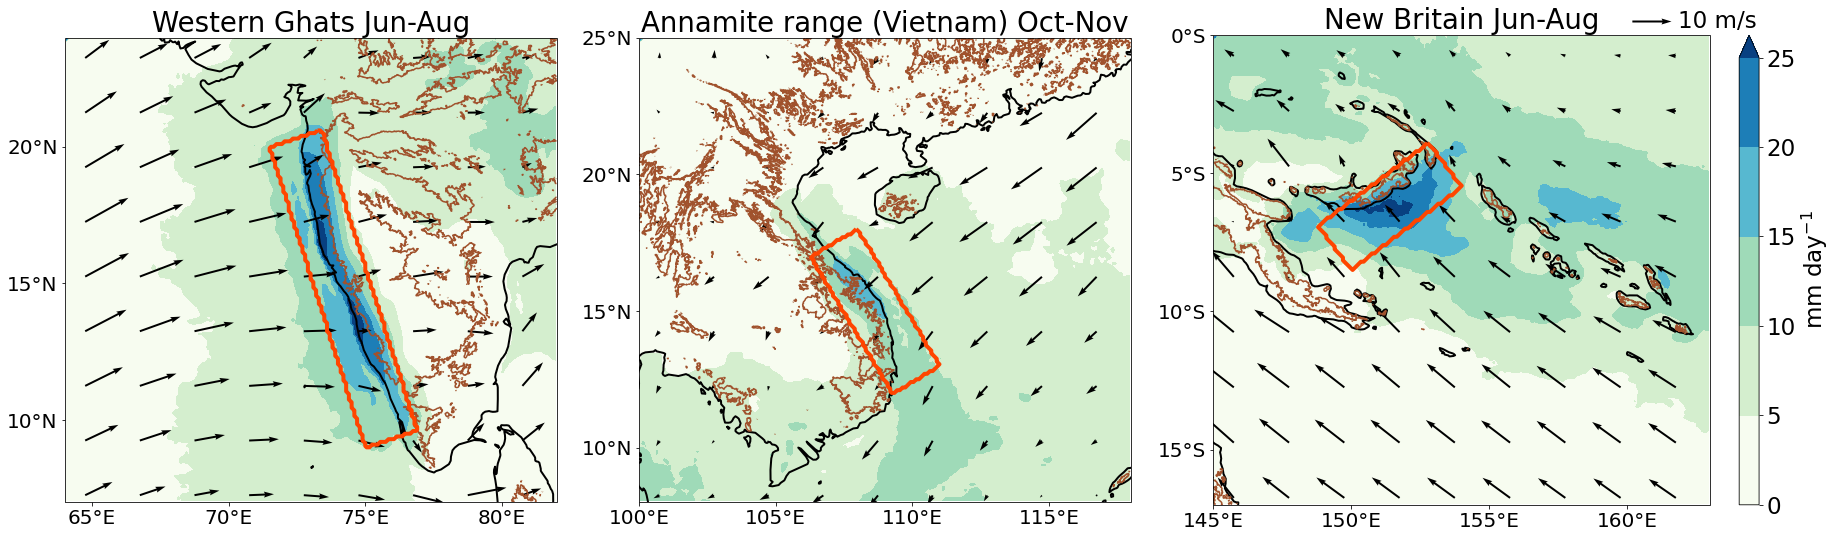

In [65]:
matplotlib.rcParams.update({'font.size': 23})

fig = plt.figure(figsize=(26,12))
spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios= [1,1,1.11],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')
    ax.coastlines(linewidth=2)
    
    box=MR.box
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    c=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.5],colors=['sienna'])
    tilted_rect(pr,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['-'],linewidths=[4.],colors=['orangered'])

    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=120,scale_units='height',width=2,units='dots')
    
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(["%i°E"%lon for lon in lons])
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    if np.mean(lats)>=0:
        ax.set_yticklabels(["%i°N"%lat for lat in lats])
    else:
        ax.set_yticklabels(["%i°S"%(-lat) for lat in lats])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1])
    ax.tick_params(labelsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$',shrink=0.7)

# Quiver key (reference wind arrow)
qk = axs[2].quiverkey(Q, 0.92, 1.03, 10, r'10 m/s', labelpos='E',
                   coordinates='axes',color='k')

    
fig.tight_layout()


# Fig - precip and BL scatterplots

In [5]:
from scipy.optimize import curve_fit
def fit(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq

def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=100):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.zeros(nsamples)
    for i in range(nsamples):
        means[i]=select_bootstrap_sample(data).mean()
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.


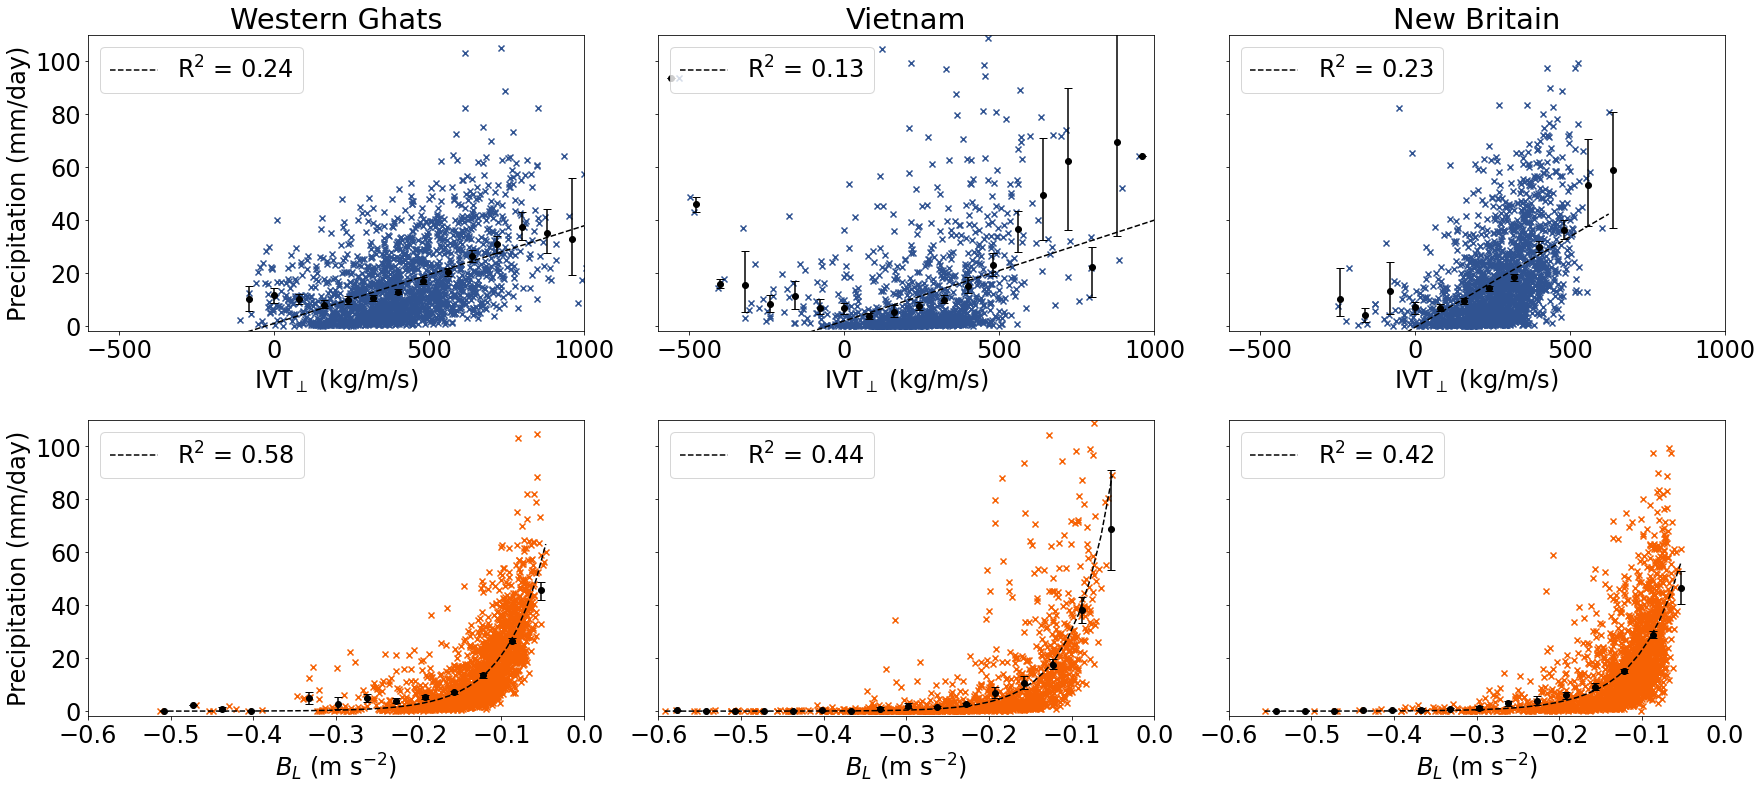

In [66]:
fig,axss = plt.subplots(2,3,figsize=(25,11.5))
for j,MR in enumerate(MRs):
    axs = axss[:,j]
    pr = MR.vars['GPM_PR_ABOVE_DAILY']
    viwvperp = MR.vars['VIWV_PERP_UPSTREAM_DAILY']
    Blsemisimple = MR.vars['BLSEMISIMPLE_ABOVE_DAILY']
    
    for i,(pred,c,model,bins) in enumerate(zip((viwvperp,Blsemisimple),('#305391','#F66103'),('linear','exponential'),(np.linspace(-600,1000,21),np.linspace(-0.7,0,21)))):
        axs[i].scatter(pred,pr,marker='x',color=c)
        x,y,rsq = fit(pred,pr,model)
        axs[i].plot(x,y,color='k',linestyle='--',label=r'R$^2$ = %.2f'%rsq)
        centers,means,q02,q98 = get_binned(pred,pr,bins,bootstrap=True)
        axs[i].errorbar(centers,means,yerr=[means-q02,q98-means],fmt='ok',ecolor='k',capsize=4)
        
        axs[i].set_ylabel("Precipitation (mm/day)")
        axs[0].set_title(MR.Lname)
        axs[i].legend(loc=2)
        axs[i].set_ylim(-2,110)
    axs[0].set_xlabel(r"IVT$_\perp$ (kg/m/s)")
    axs[1].set_xlabel(r"$B_L$ (m s$^{-2}$)")
    axs[0].set_xlim(-600,1000)
    axs[1].set_xlim(-0.6,0)  

for ax in axss[:,1:].reshape(-1):
    ax.set_ylabel('')
    ax.set_yticklabels([])
    fig.tight_layout()

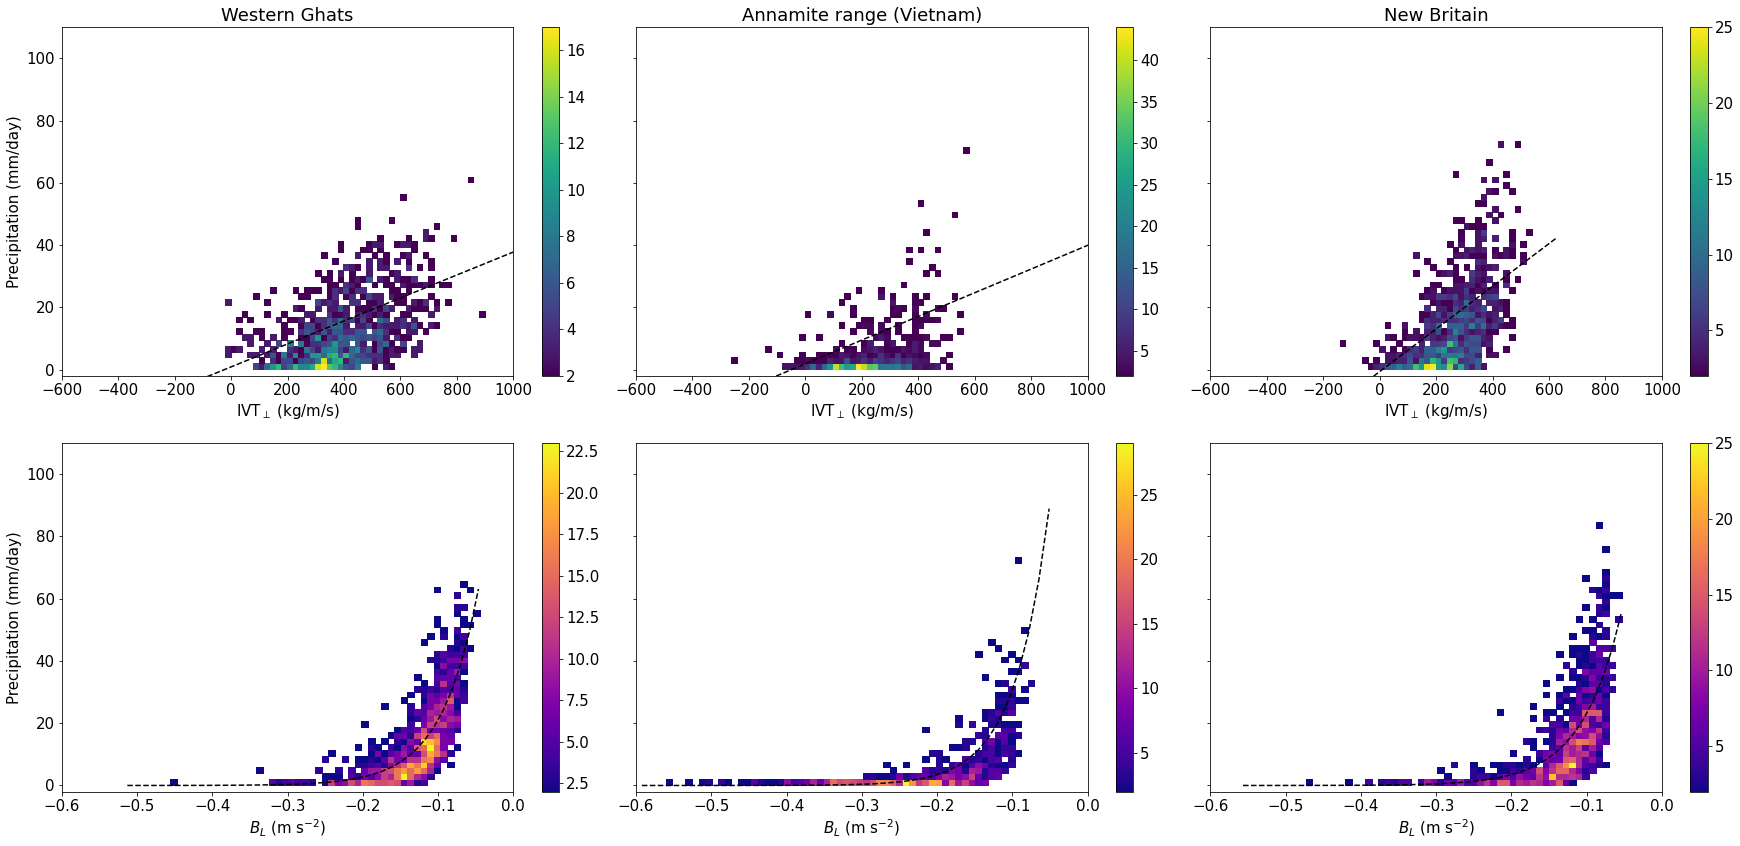

In [8]:
fig,axss = plt.subplots(2,3,figsize=(25,12))
for j,MR in enumerate(MRs):
    axs = axss[:,j]
    pr = MR.vars['GPM_PR_ABOVE_DAILY']
    viwvperp = MR.vars['VIWV_PERP_UPSTREAM_DAILY']
    Blsemisimple = MR.vars['BLSEMISIMPLE_ABOVE_DAILY']
    
    for i,(pred,cm,model,bins) in enumerate(zip((viwvperp,Blsemisimple),(plt.cm.viridis,plt.cm.plasma),('linear','exponential'),(np.linspace(-600,1000,81),np.linspace(-0.7,0,81)))):
        #axs[i].scatter(pred,pr,marker='x',color=c)
        h=axs[i].hist2d(pred,pr, bins=[bins,np.linspace(0.,150,81)], cmin=2,cmap=cm)#, cmin=10)
        plt.colorbar(h[-1],ax=axs[i])
        x,y,rsq = fit(pred,pr,model)
        axs[i].plot(x,y,color='k',linestyle='--',label=r'R$^2$ = %.2f'%rsq)
        #centers,means,q02,q98 = get_binned(pred,pr,bins,bootstrap=True)
        #axs[i].errorbar(centers,means,yerr=[means-q02,q98-means],fmt='ok',ecolor='k',capsize=4)
        
        axs[i].set_ylabel("Precipitation (mm/day)")
        axs[0].set_title(MR.Lname)
        #axs[i].legend(loc=2)
        axs[i].set_ylim(-2,110)
    axs[0].set_xlabel(r"IVT$_\perp$ (kg/m/s)")
    axs[1].set_xlabel(r"$B_L$ (m s$^{-2}$)")
    axs[0].set_xlim(-600,1000)
    axs[1].set_xlim(-0.6,0)  

for ax in axss[:,1:].reshape(-1):
    ax.set_ylabel('')
    ax.set_yticklabels([])
    fig.tight_layout()

# Fig - controls on BL

In [44]:
# Evaluating slopes theoretically
alpha = 20.6/3600*2.5e6
dBLdqL = 1/(11.3*3600)*1004*8000/alpha
dBLdTL = -1/(2.7*3600)*1004*8000/alpha
dBLdeb = 1/(11.5*3600)*1004*8000/alpha

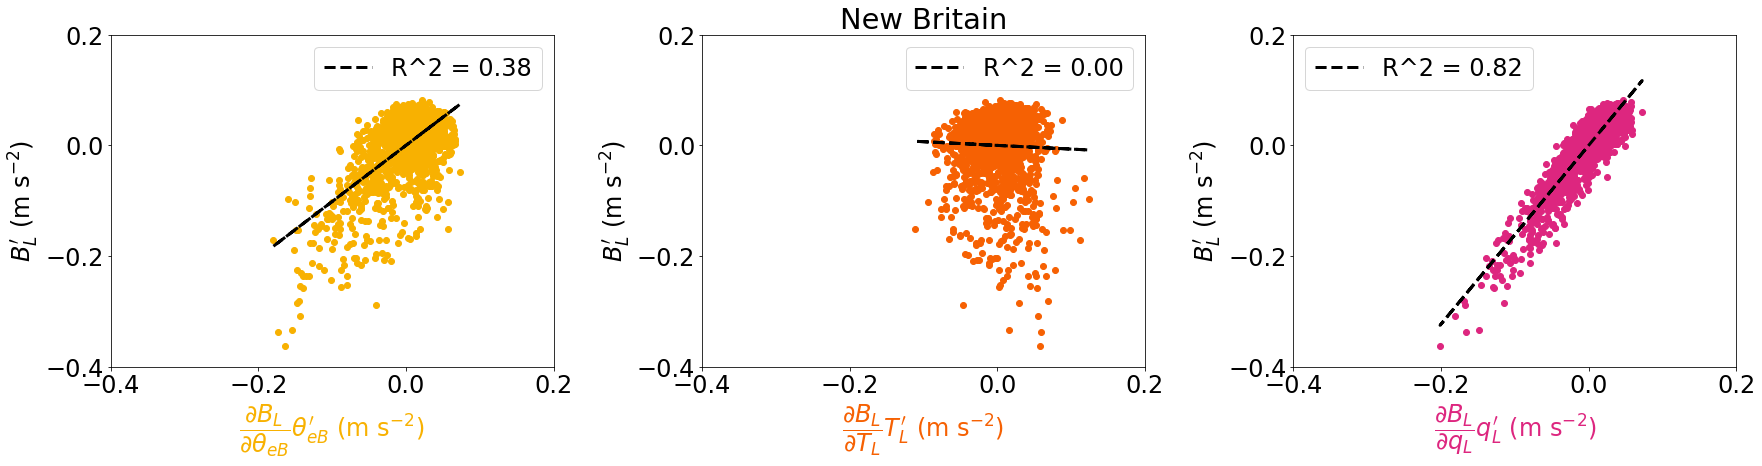

In [48]:
matplotlib.rcParams.update({'font.size':24})
fig,axs = plt.subplots(1,3,figsize=(25,7))
MR = Newbritain#
deltaBl_above = MR.vars['BLSEMISIMPLE_ABOVE_DAILY'] - MR.vars['BLSEMISIMPLE_ABOVE_DAILY'].mean("time")

predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
predeb = dBLdeb*(MR.vars['EBSEMI_ABOVE_DAILY']-MR.vars['EBSEMI_ABOVE_DAILY'].mean('time'))
clrs = ('#F8B101','#F66103','#DD267F')
for j,(pred,c) in enumerate(zip((predeb,predTL,predqL),clrs)):
    reg = linregress(pred,deltaBl_above)
    axs[j].scatter(pred,deltaBl_above,color=c)
    axs[j].plot(pred,reg.intercept+reg.slope*pred,color='k',linewidth=3,linestyle='--',label = 'R^2 = %.2f'%(reg.rvalue**2))
    axs[j].set_ylabel(r"$B_L'$ (m s$^{-2}$)")
    axs[j].legend()
    axs[j].set_xlim(-0.4,0.2)
    axs[j].set_ylim(-0.4,0.2)
axs[0].set_xlabel(r"$\dfrac{\partial B_L}{\partial \theta_{eB}}\theta_{eB}'$ (m s$^{-2}$)",color=clrs[0])
axs[1].set_xlabel(r"$\dfrac{\partial B_L}{\partial T_L} T_L'$ (m s$^{-2}$)",color=clrs[1])
axs[2].set_xlabel(r"$\dfrac{\partial B_L}{\partial q_L} q_L'$ (m s$^{-2}$)",color=clrs[2])
axs[1].set_title(MR.Lname)

fig.tight_layout()

# Fig - regressions TL

In [29]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [30]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label=r'%i m/s/K'%ref, labelpos='E', coordinates='axes',color='k')
        
def add_latlon(ax,box):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(["%i°E"%lon for lon in lons])
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    if np.mean(lats)>=0:
        ax.set_yticklabels(["%i°N"%lat for lat in lats])
    else:
        ax.set_yticklabels(["%i°S"%(-lat) for lat in lats])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    
clrs = ('#F8B101','#F66103','#DD267F')
     

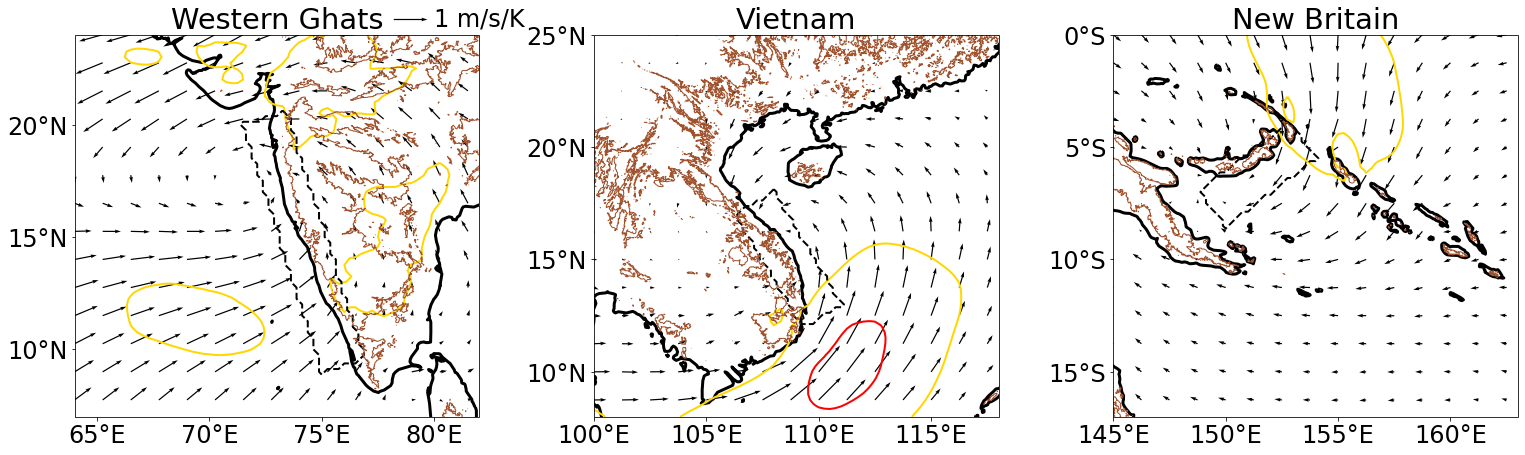

In [162]:
matplotlib.rcParams.update({'font.size':24})
fig,axs = plt.subplots(1,3,figsize=(22,6.6),subplot_kw={"projection":ccrs.PlateCarree()})

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    predqL = (MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = -(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=12,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=12,ref=1,pos=(0.87,1.04))
        
    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()

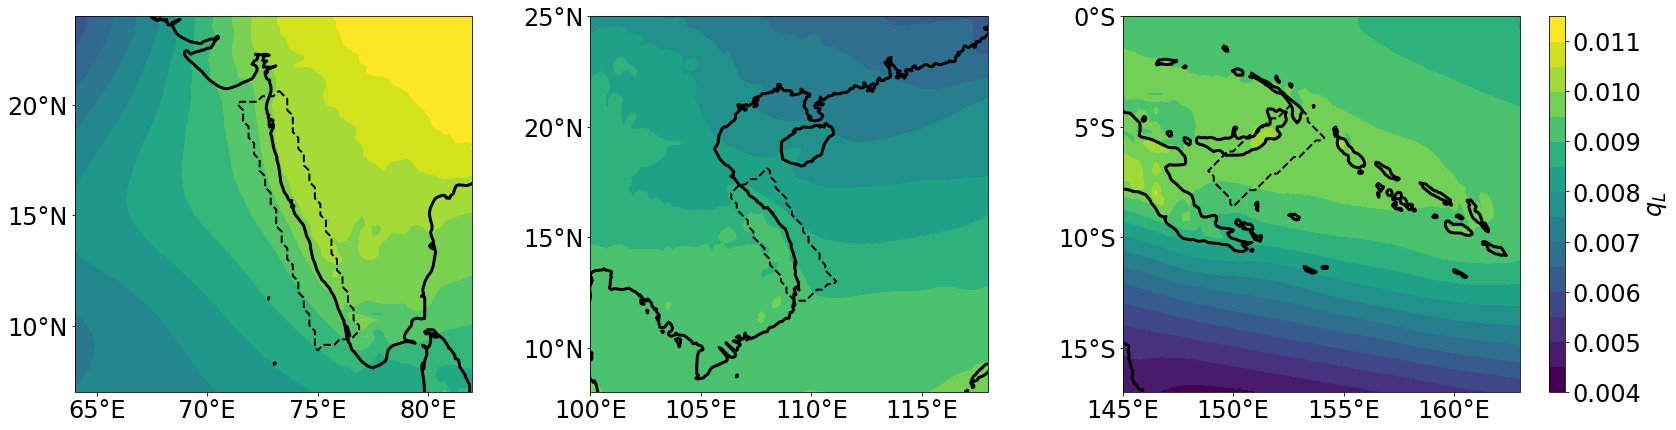

In [91]:
matplotlib.rcParams.update({'font.size':24})
fig = plt.figure(figsize=(24,6.5))
spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios= [1,1,1.11],figure=fig)
axs=[]

for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i],projection= ccrs.PlateCarree())
    plot = MR.vars['QLSEMI_DAILY'].mean('time')
    c = plot.plot.contourf(ax=ax,levels=np.arange(4e-3,12e-3,5e-4),transform = ccrs.PlateCarree(),add_colorbar=False)
    
    tilted_rect(plot,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title("")
    add_latlon(ax,MR.box)
    
# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'$q_L$',shrink=0.7)


fig.tight_layout()

# Spatial pattern of BL

In [103]:
Vietnam.Lname='Vietnam'

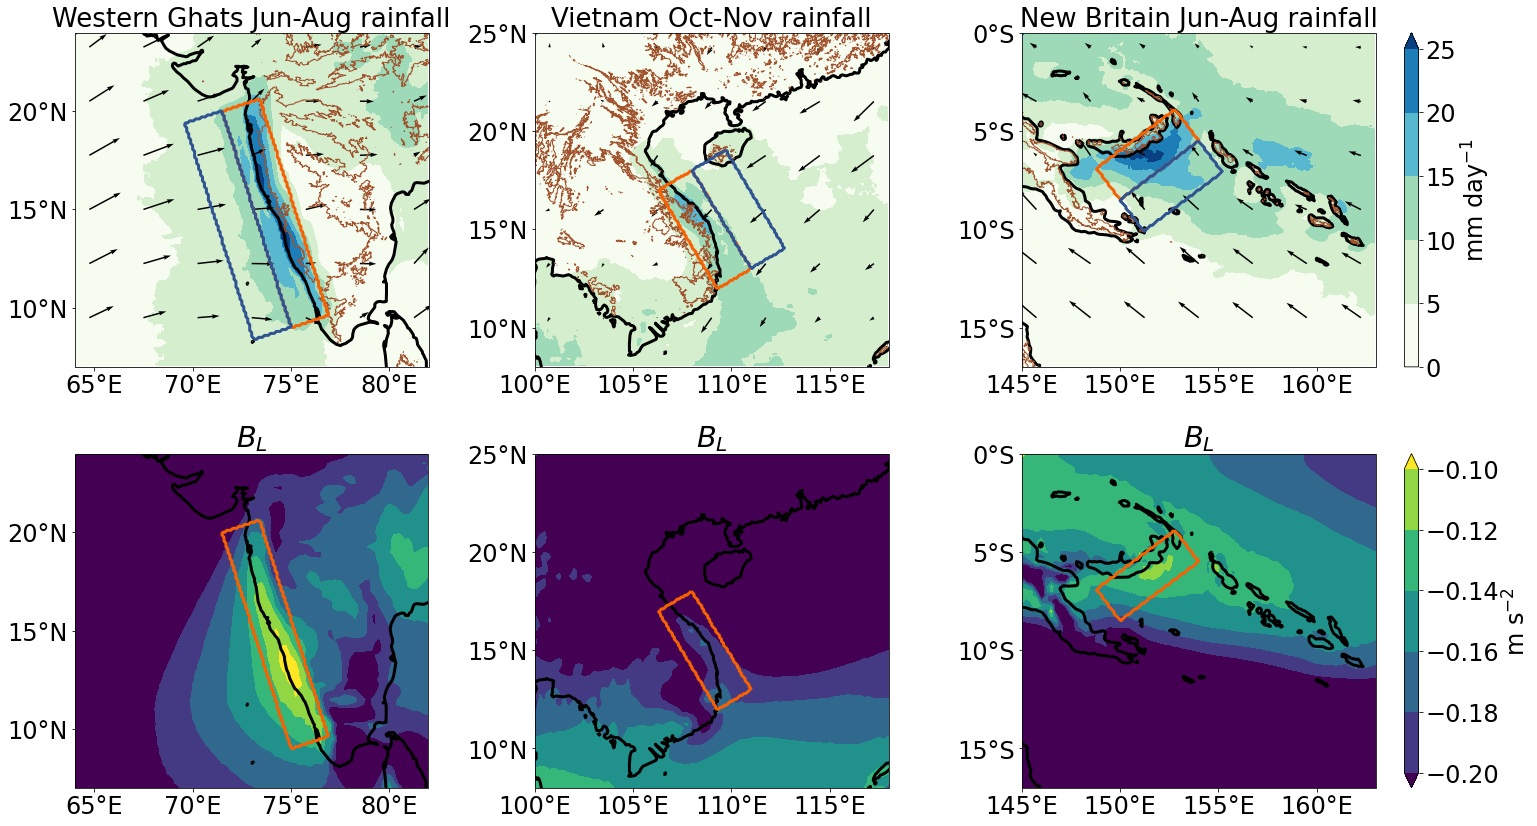

In [60]:
matplotlib.rcParams.update({'font.size':24})
fig = plt.figure(figsize=(22,12))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]

for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[0,i],projection= ccrs.PlateCarree())
    ax.coastlines(linewidth=3)
    box=MR.box
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    cpr=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['sienna'])
    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//6
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=120,scale_units='height',width=1.5,units='dots')
    
    tilted_rect(pr,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['-'],linewidths=[3.],colors=['#F66103'])
    tilted_rect(pr,*MR.box_tilted,reverse=True).plot.contour(ax=ax,levels=[0.5],linestyles=['-'],linewidths=[3.],colors=['#305391'])
    
    add_latlon(ax,box)
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1]+ ' rainfall',fontsize=26)
    

    
ax1=ax
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[1,i],projection= ccrs.PlateCarree())
    ax.coastlines(linewidth=3)
    box=MR.box
    BL = MR.vars['BLSEMISIMPLE_DAILY'].mean('time')
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    cbl = BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-0.2,-0.1,6),cmap=plt.cm.viridis,add_colorbar=False)
    
    grid=sel_box(gpm_pr_seasmean,box)
    tilted_rect(grid,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['-'],linewidths=[3.],colors=['#F66103'])
    
    add_latlon(ax,box)
    ax.set_title(r'$B_L$')

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cpr, cax=cax,label=r'mm day$^{-1}$',shrink=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cbl, cax=cax,label=r'm s$^{-2}$',shrink=0.7)




fig.tight_layout()

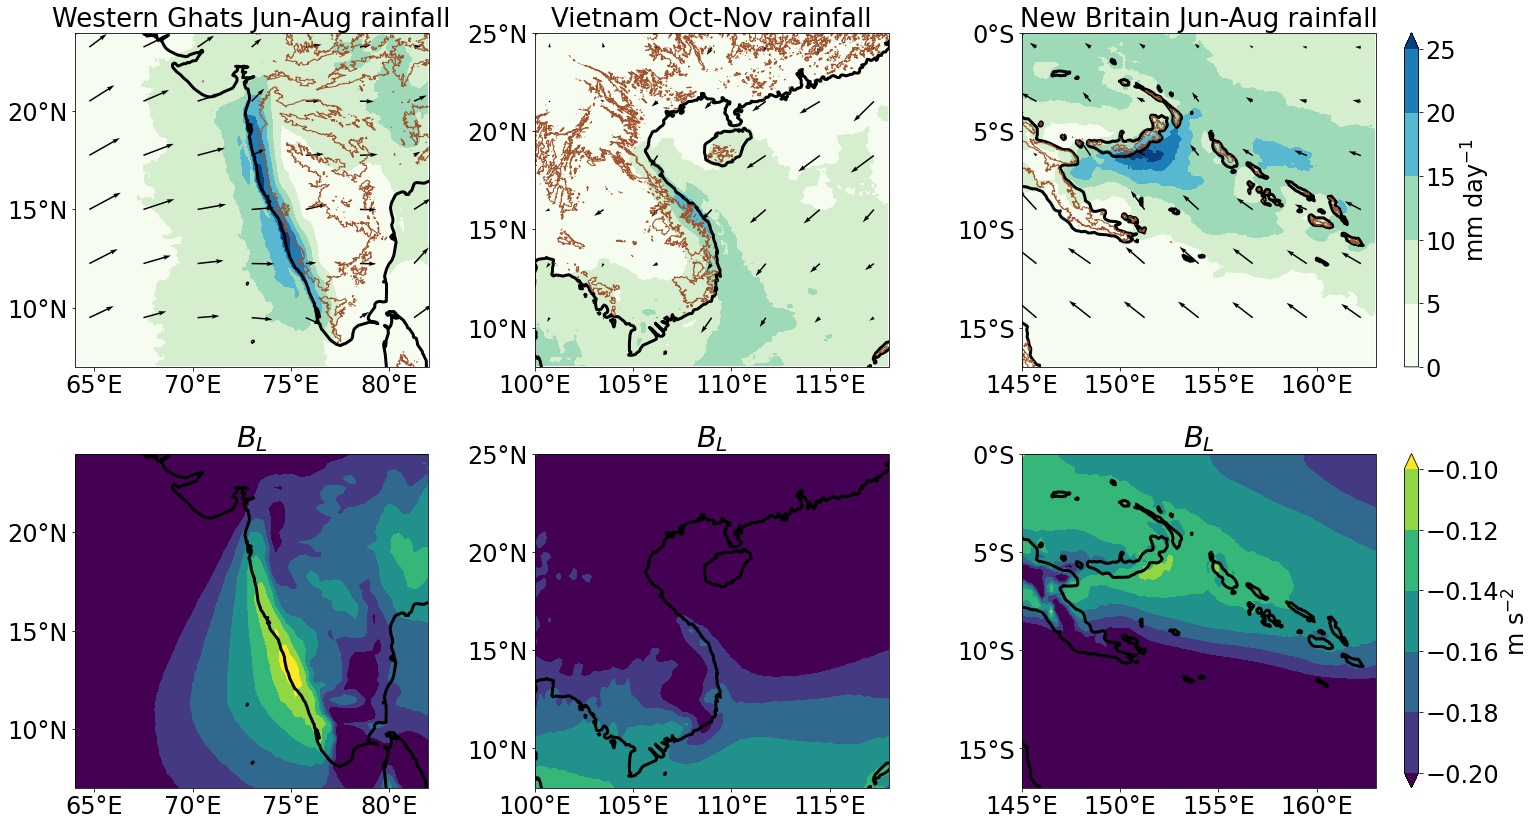

In [72]:
matplotlib.rcParams.update({'font.size':24})
fig = plt.figure(figsize=(22,12))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]


for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[0,i],projection= ccrs.PlateCarree())
    ax.coastlines(linewidth=3)
    box=MR.box
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    cpr=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['sienna'])
    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//6
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=120,scale_units='height',width=1.5,units='dots')
    
    add_latlon(ax,box)
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1]+ ' rainfall',fontsize=26)
    

    
ax1=ax
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[1,i],projection= ccrs.PlateCarree())
    ax.coastlines(linewidth=3)
    box=MR.box
    BL = MR.vars['BLSEMISIMPLE_DAILY'].mean('time')
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    cbl = BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-0.2,-0.1,6),cmap=plt.cm.viridis,add_colorbar=False)
    
    grid=sel_box(gpm_pr_seasmean,box)

    add_latlon(ax,box)
    ax.set_title(r'$B_L$')

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cpr, cax=cax,label=r'mm day$^{-1}$',shrink=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cbl, cax=cax,label=r'm s$^{-2}$',shrink=0.7)




fig.tight_layout()

# Linear theory

In [24]:
from orographicConvectionTheory.orographicConvectionTheory import k_vector,compute_Lq,lapse_rates

In [25]:
def m_exponent_2D(sigma,N,ksq):
    den = sigma**2
    EPS=1e-15
    den[den < EPS] = EPS
    return (den>=N**2)*1j*np.sqrt(ksq*(1-N**2/den)+0.j) + (den<N**2)*np.sign(sigma)*np.sqrt(ksq*(N**2/den-1)+0.j)

def linear_precip_theory_2D(xx,yy,hxy,U,V,tauT=3,tauq=11,P0=4.,switch=1,pad_factor=0.2):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lc=2.5e6
    dx = xx[1]-xx[0]
    dy = yy[1]-yy[0]
    tauT*=3600
    tauq*=3600
    
    # Pad boundaries
    calc_pad = int(pad_factor*np.max(hxy.shape))
    pad=calc_pad#pad = min([calc_pad, 200])
    pad_topo = int(100e3/dx)
    hxy_pad_topo = np.pad(hxy, pad_topo, 'linear_ramp',end_values = [0,0])
    hxy_pad = np.pad(hxy_pad_topo,pad-pad_topo,'constant')
    xx_pad = np.pad(xx, pad, 'linear_ramp',end_values = [xx[0]-pad*dx,xx[-1]+pad*dx])
    yy_pad = np.pad(yy, pad, 'linear_ramp',end_values = [yy[0]-pad*dy,yy[-1]+pad*dy])
    
    z=np.arange(0,10000,100)
    kx=k_vector(len(xx_pad),dx)
    ky=k_vector(len(yy_pad),dy)
    sigma = U*kx[:,None]+V*ky[None,:]
    ksq = kx[:,None]**2+ky[None,:]**2
    
    LqovU=compute_Lq(5,1,tauq)
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lc * 86400
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    
    
    m1 = m_exponent_2D(sigma,N,ksq)
    mm = np.copy(m1)
    mm[mm==0]=1e-8
    Pprimehat = (1j*sigma/(1j*sigma + switch*1/LqovU)) * chi * np.fft.fft2(hxy_pad) * ((m1!=0)*(np.exp( 1j* mm * ztop )-np.exp( 1j* mm * zbot ))/(1j*mm*(ztop-zbot)) + (m1==0)*1) #np.exp( 1j* m_exponent_2D(sigma,N,ksq)[:,:,None] *  z_slice[None,None,:] ).mean(axis=-1) 

    P = P0 + np.real(np.fft.ifft2(Pprimehat))
    P = np.maximum(0.,P)[pad:-pad, pad:-pad]
    return xr.DataArray(P,coords={'x':xx,'y':yy},dims=['x','y'])
    #P = np.maximum(0.,P)
    #return xr.DataArray(P,coords={'x':xx_pad,'y':yy_pad},dims=['x','y'])


In [26]:
def p_lineartheory_region(MR,U,V,topo='ETOPO',P0=4,tauT=7.5,tauq=27.5,pad='small'):
    if topo=='ETOPO':
        z = MR.vars['Z_HR']
    elif topo=='ETOPOCOARSE':
        z = MR.vars['Z_HR'].coarsen(latitude=4,longitude=4,boundary='trim').mean()
    elif topo=='ERA5':
        z = MR.vars['Z']
    else:
        raise ValueError('topo')
    hxy = np.array(z).T[:,::-1]
    lon = z.longitude
    lat = z.latitude[::-1]
    
    xx = np.array(lon)*100e3
    yy = np.array(lat)*100e3
    
    if pad=='small':
        pf=0.2
    elif pad=='big':
        pf=2
    P = linear_precip_theory_2D(xx,yy,hxy,U,V,tauT=tauT,tauq=tauq,P0=P0,pad_factor=pf)
    return P.assign_coords({'longitude':P.x/100e3,'latitude':P.y/100e3}).swap_dims({'x':'longitude','y':'latitude'})[:,::-1].transpose()


In [42]:
ptheory = p_lineartheory_region(Ghats,10,1,P0=2)

In [43]:
Vietnam.Lname='Vietnam'

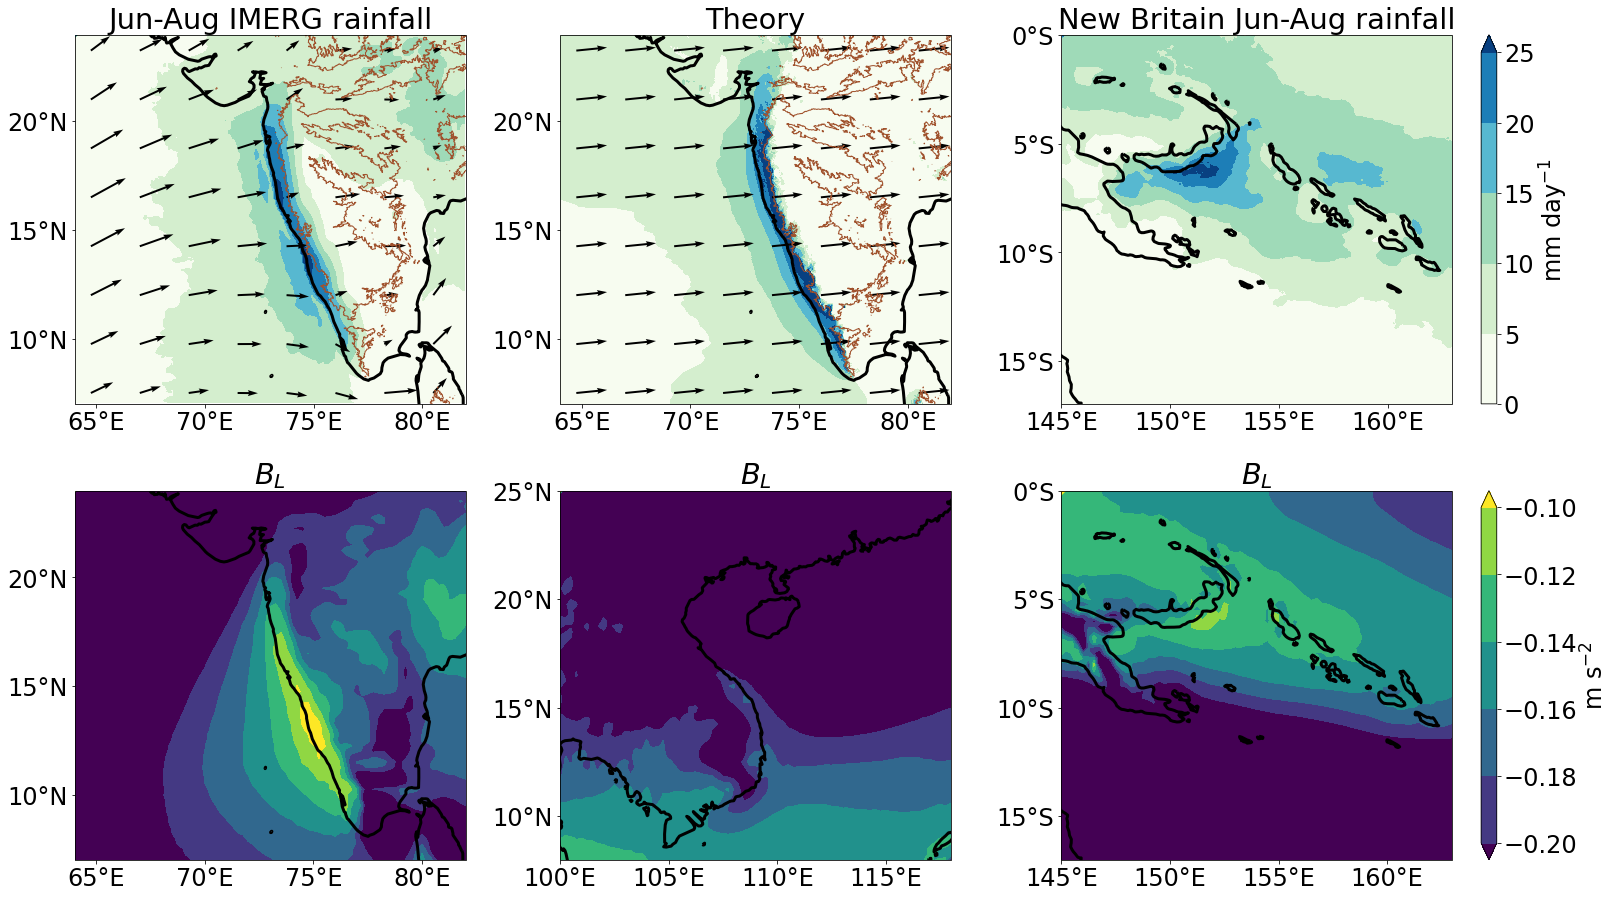

In [71]:
matplotlib.rcParams.update({'font.size':24})
fig = plt.figure(figsize=(2,15))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
axsbl=[]

for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[0,i],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax.coastlines(linewidth=3)
    box=MR.box
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    cpr=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    add_latlon(ax,box)
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1]+ ' rainfall')

for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[1,i],projection= ccrs.PlateCarree())
    axsbl.append(ax)
    ax.coastlines(linewidth=3)
    box=MR.box
    BL = MR.vars['BLSEMISIMPLE_DAILY'].mean('time')
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    cbl = BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-0.2,-0.1,6),cmap=plt.cm.viridis,add_colorbar=False)
    add_latlon(ax,box)
    ax.set_title(r'$B_L$')

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[-1])
cax1 = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cpr, cax=cax1,label=r'mm day$^{-1}$',shrink=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cbl, cax=cax,label=r'm s$^{-2}$',shrink=0.7)


ptheory.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
axs[1].set_title('linear theory')

MR=Ghats
u=sel_months(sel_box(era5100u_seasmean,MR.box),MR.months).mean('month')
v=sel_months(sel_box(era5100v_seasmean,MR.box),MR.months).mean('month')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=len(u.latitude)//7
m=n
ibeg=3
iend=-1
Q=axs[0].quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=120,scale_units='height',width=2,units='dots')

u=u**0*10
v=v**0
Q=axs[1].quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=120,scale_units='height',width=2,units='dots')


sel_box(topo_hires,MR.box).plot.contour(ax=axs[0],transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['sienna'])
sel_box(topo_hires,MR.box).plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['sienna'])

add_latlon(axs[0],Ghats.box)
add_latlon(axs[1],Ghats.box)

axs[0].set_title( monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1]+ ' IMERG rainfall')
axs[1].set_title('Theory')

fig.tight_layout()